# Frame the problem

**Challenge** : Predict the consumption of electrictity in Paris every 15 minutes at J+1

**Goal** : implement a model to estimate the electrictity consumption based on some historical data. It is a typical supervised learning task since we will be working with some labelled training examples (each instance comes with the expected output, ie. the electricity consumption in Paris for a given date). Moreover, it is also a typical regression task, since we try to predict a value. More specifically this is a multivariate regression problem since the system will use multiple features to make a prediction.

# Select a performance measure

Accuracy of the models will be measured with the **mean absolute percentage error (MAPE)**.  
It is basically a measurement of prediction accuracy.

$ M = \frac{100\%}{n} \sum_{i=1}^n | \frac{C_i - {C_i}^*}{C_i} |\ $


where $C_i$  is the real consumption, $C_i^∗$ the estimated consumption, and n the number of guess (96 for one day).


# Get the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import requests
import bs4 as BeautifulSoup
import datetime
from modules.utils import get_data_with_features

In [2]:
from modules.utils import get_data_with_features,is_day_off

df = get_data_with_features()

In [22]:
df.head(10)
df.columns

Index(['Date', 'Conso', 'Temp', 'is_day_off', 'conso_24_lag', 'temp_24_lag',
       'conso_7_days_lag', 'heating_degrees', 'cooling_degrees', 'is_weekend',
       'day_of_week', 'temp_rolling_7_days', 'month'],
      dtype='object')

# Take a quick look

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86097 entries, 337 to 86433
Data columns (total 13 columns):
Date                   86097 non-null datetime64[ns]
Conso                  86097 non-null float64
Temp                   86097 non-null float64
is_day_off             86097 non-null int64
conso_24_lag           86097 non-null float64
temp_24_lag            86097 non-null float64
conso_7_days_lag       86097 non-null float64
heating_degrees        86097 non-null float64
cooling_degrees        86097 non-null float64
is_weekend             86097 non-null int64
day_of_week            86097 non-null int64
temp_rolling_7_days    86097 non-null float64
month                  86097 non-null int64
dtypes: datetime64[ns](1), float64(8), int64(4)
memory usage: 9.2 MB


In [6]:
df.describe()

,Conso,Temp,is_day_off,conso_24_lag,temp_24_lag,conso_7_days_lag,heating_degrees,cooling_degrees,is_weekend,day_of_week,temp_rolling_7_days,month
count,86097.000000,86097.000000,86097.000000,86097.000000,86097.000000,86097.000000,86097.000000,86097.000000,86097.000000,86097.000000,86097.000000,86097.000000
mean,8229.491841,11.990402,0.045158,8229.170505,11.991207,8223.136625,6.845331,0.158658,0.285445,2.998502,11.998792,6.467821
std,2167.432896,7.087520,0.207653,2167.106115,7.086936,2161.359658,5.796149,0.898975,0.451629,1.999724,6.117692,3.400197
min,3982.000000,-10.542000,0.000000,3982.000000,-10.542000,3982.000000,0.000000,0.000000,0.000000,0.000000,-3.032690,1.000000
25%,6634.000000,6.808000,0.000000,6634.000000,6.822800,6634.000000,1.170000,0.000000,0.000000,1.000000,7.246920,4.000000
50%,7964.000000,11.800000,0.000000,7963.000000,11.800000,7960.000000,6.200000,0.000000,0.000000,3.000000,11.928750,6.000000
75%,9677.000000,16.830000,0.000000,9677.000000,16.830000,9667.000000,11.192000,0.000000,1.000000,5.000000,17.191144,9.000000
max,15286.000000,38.060000,1.000000,15286.000000,38.060000,15286.000000,28.542000,14.060000,1.000000,6.000000,25.751423,12.000000


/Users/lucasberbesson/.local/share/virtualenvs/ds2-zTZpun2G/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


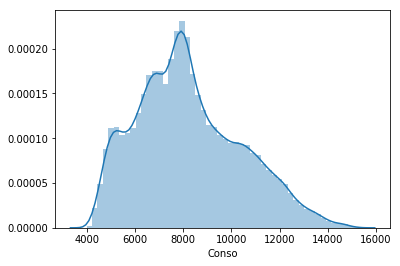

In [7]:
sns.distplot(df['Conso'])

/Users/lucasberbesson/.local/share/virtualenvs/ds2-zTZpun2G/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


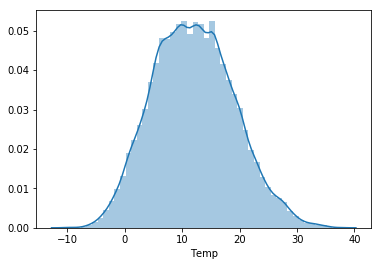

In [8]:
sns.distplot(df['Temp'])

# Create a test set

A test set must be set aside as soon as possible to avoid overfitting.   
Creating a test set is theoretically quite simple: just pick some instances randomly,
typically 20% of the dataset, set them aside and you are done.

In [9]:
import numpy as np
import numpy.random as rnd

def split_train_test(df,test_ratio=0.25):
    rnd.seed(42)
    shuffled = rnd.permutation(len(df))
    test_set_size = int(len(df)*test_ratio)
    test_indices = shuffled[:test_set_size]
    train_indices = shuffled[test_set_size:]
    return df.iloc[train_indices],df.iloc[test_indices]

In [10]:
train_set, test_set = split_train_test(df, 0.2)
print(len(train_set), "train +", len(test_set), "test")

68878 train + 17219 test


But scikit learn provides a function to do that : 

In [11]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, random_state=42)

Note : random sampling is good if the dataset is large enough relative to the number of attributes, when it is not your risk of introducing a sampling bias and should prefere a stratified sampling. 

# Discover and visualize the data

Now the goal is to go a little bit more in depth. First, make sure you have put the test set aside and you are only exploring the training set.

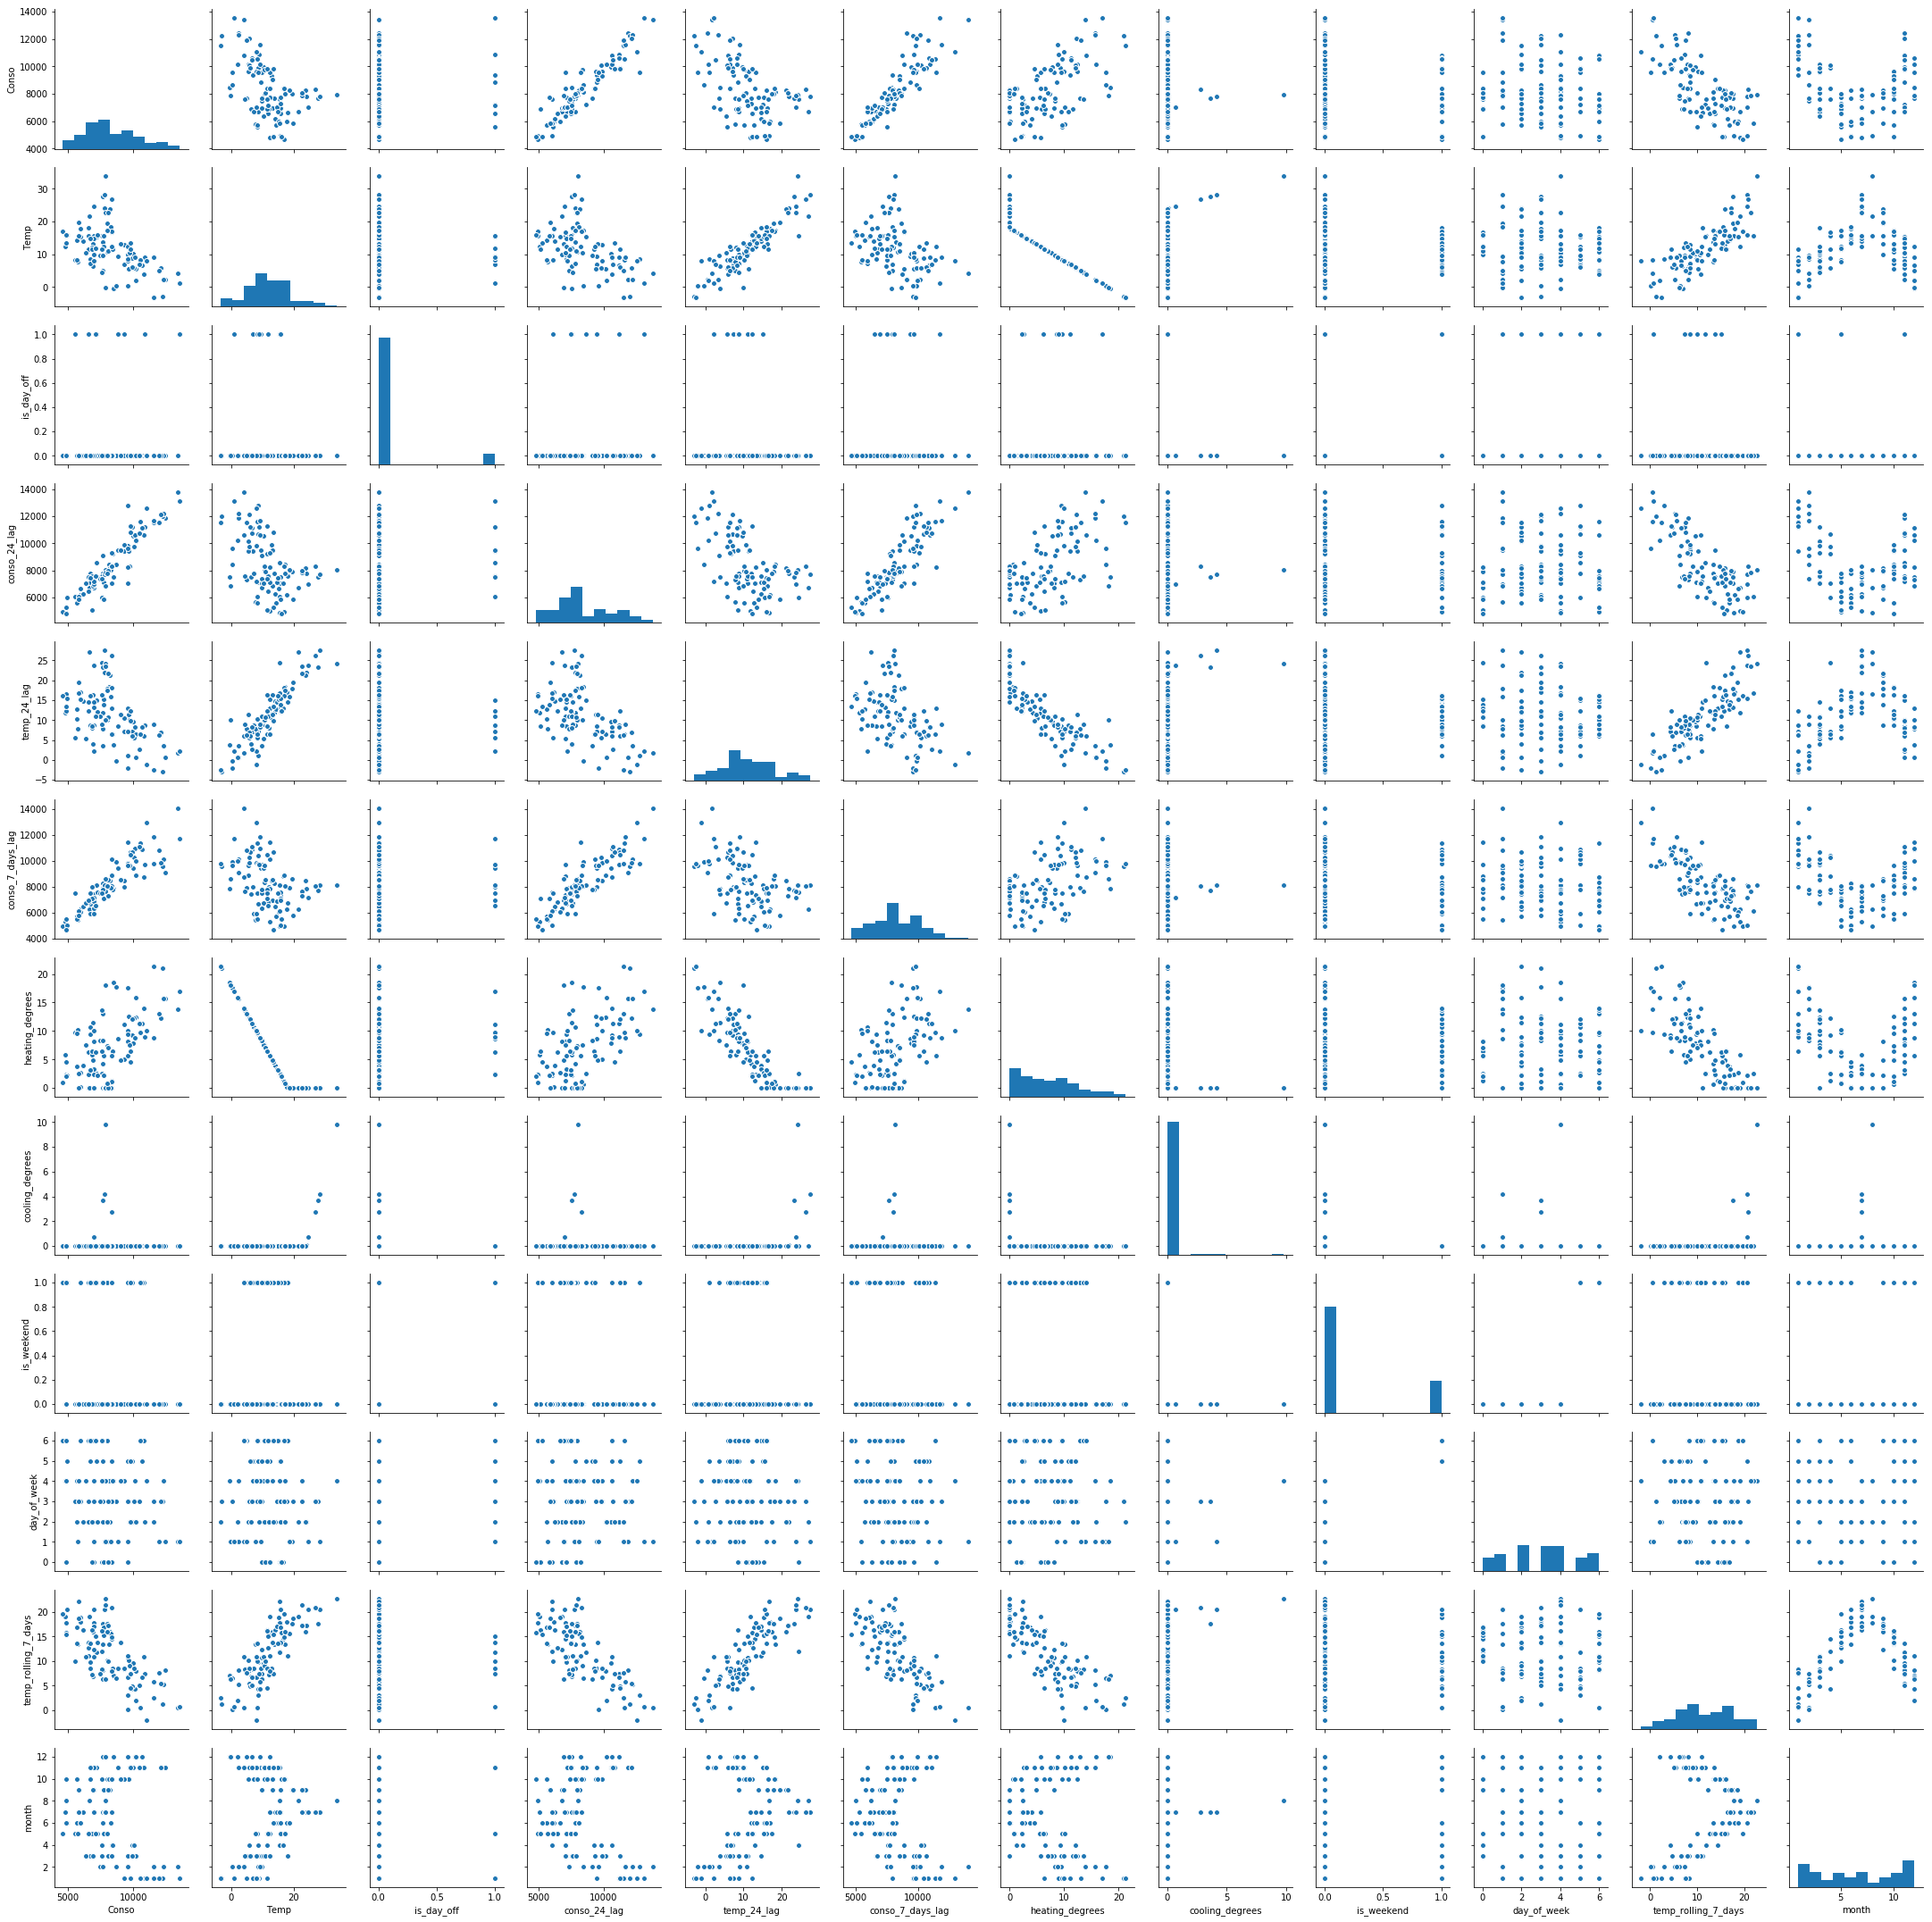

In [12]:
%matplotlib inline
sns.pairplot(train_set.head(100))

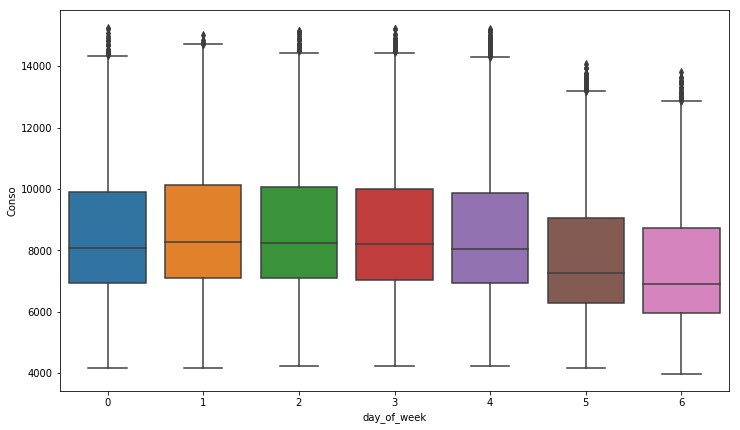

In [14]:
plt.figure(figsize=(12, 7))

sns.boxplot(x='day_of_week',y='Conso',data=train_set)

In [16]:
import plotly.offline as py
import plotly.graph_objs as go


data = [go.Scatter( x=df['Date'], y=(df["Conso"]))]
py.plot(data)

'file:///Users/lucasberbesson/code/ds2/temp-plot.html'

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(df.corr(),cmap='coolwarm')

# Prepare the data

In [17]:
X_train = train_set.drop(["Conso"], axis=1)
y_train = train_set["Conso"].copy()

X_test = train_set.drop(["Conso"], axis=1)
y_test = train_set["Conso"].copy()

## Feature scaling

Most of machine learning algorithm are based on distances (for example the euclidian distance).   
When features have very different scales this can cause issues, the distances are dominated by some columns ....  
There are two types of feature scaling : **Standardisation** and **Normalisation**. 

Feature scaling can also help algorithm to converge faster. 


### Standardisation
This one does not bound values to a range but is less affected by outliers (which would crush values in normalisation...)

$$X_{stand} = \frac{x - mean(x)}{std(x)}$$


In [19]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
X_train_scaled= std_scaler.fit_transform(X_train[['Temp','temp_24_lag']])

In [20]:
X_train_scaled

array([[-0.72071732, -0.67921065],
       [ 0.03066564, -0.04237244],
       [-0.36953463, -0.49600481],
       ...,
       [ 2.04783338,  1.5507833 ],
       [-2.47262453, -1.45882502],
       [-1.48001851, -0.99374228]])

In [21]:
X_train.head()

,Date,Temp,is_day_off,conso_24_lag,temp_24_lag,conso_7_days_lag,heating_degrees,cooling_degrees,is_weekend,day_of_week,temp_rolling_7_days,month
52600,2016-01-01 19:30:00,6.920000,1,9442.0,7.225,7970.0,11.080000,0.0,0,4,8.315814,1
61969,2016-07-15 00:00:00,12.234000,0,5024.0,11.730,5313.0,5.766000,0.0,0,4,19.066656,7
32633,2014-11-11 20:00:00,9.403667,1,9478.0,8.521,9410.0,8.596333,0.0,0,1,8.582823,11
21105,2014-03-16 16:00:00,18.100000,0,7608.0,14.460,6713.0,0.000000,0.0,1,6,11.121086,3
74164,2017-03-26 01:30:00,8.504500,0,7101.0,8.495,6647.0,9.495500,0.0,1,6,9.812394,3


## Handling text attributes
Most machine learning algorithm prefer to work with numerical values so you will need to convert text labels to numbers.


### OneHotEncoding
If you have ordinal categories (with a notion of order, like for example the size of a t-shirt), then transforming text categories to 1,2,3 ... is good, as long as the number attributed are in the same order.  
But if you have nominal attributes, this notion of order will bias your model, so you need to make further transformations to your dataset. 


# Building pipelines 

Scikit learn pipelines allow us to perform many transformations at once and save time.   
Each transformer output is sent as an input of the next transformer. 

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [25]:
X_train.columns

Index(['Date', 'Temp', 'is_day_off', 'conso_24_lag', 'temp_24_lag',
       'conso_7_days_lag', 'heating_degrees', 'cooling_degrees', 'is_weekend',
       'day_of_week', 'temp_rolling_7_days', 'month'],
      dtype='object')

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.pipeline import FeatureUnion



num_attribs = ['Temp','temp_24_lag','conso_24_lag','conso_7_days_lag','heating_degrees','cooling_degrees']
cat_attribs = ['day_of_week','month']
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('std_scaler', StandardScaler()),
])
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('one_hot_encoder', OneHotEncoder()),
])
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

In [29]:
X_train_prepared = full_pipeline.fit_transform(X_train)

# Training a LinearRegression model
Let's first train a simple 

In [30]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [31]:
# let's try the full pipeline on a few training instances
some_data = X_train.iloc[:5]
some_labels = y_train.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [9053.842754   5108.92045125 9680.18028763 6524.85352774 6667.12522345]
Labels: [9337.0, 4812.0, 8833.0, 6597.0, 6691.0]


In [32]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [33]:
consumption_predictions = lin_reg.predict(X_train_prepared)
mean_absolute_percentage_error(y_train,consumption_predictions)

4.302778686454791

In [34]:
lin_reg.coef_

array([ 141.07174084,  201.82849902, 1522.87055593,  532.89961438,
        533.91076385,  -18.36575657,  755.89809952,  126.25119083,
         18.28394387,  -15.82772405,  -74.45660213, -558.05383203,
       -264.77470214,  -50.3877073 , -135.86099929, -192.59765781,
        -92.88523288,   -6.93962216,   86.69161562,   29.12732113,
         69.09028783,  140.76448085,  128.96428823,  137.6066863 ,
       -126.25308664])

# Training a decision tree model

In [35]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train_prepared, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [36]:
consumption_predictions = tree_reg.predict(X_train_prepared)
mean_absolute_percentage_error(y_train,consumption_predictions)


0.0

That's strange, we may be overfitting the data here

Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data.

## Better evaluation using cross validation

The following code performs K-fold cross-validation:   
It randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the decision tree model 10 times,
picking a different fold for evaluation every time and training on the other 9 folds.
The result is an array containing the 10 evaluation scores:


In [37]:
from sklearn.model_selection import cross_val_score

cross_val_score(tree_reg, X_train_prepared, y_train,scoring="neg_mean_absolute_error", cv=5)

array([-294.69596077, -296.60849142, -293.07666099, -291.02142378,
       -296.29900367])

# Choosing an algorithm 

In [38]:
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge

regressions = {}

X_train_prepared = full_pipeline.fit_transform(X_train)

for regressor in [ElasticNet,DecisionTreeRegressor, GradientBoostingRegressor,RandomForestRegressor,Ridge, Lasso, LinearRegression]:
    reg = regressor()
    regressions[reg.__class__.__name__] = reg
    print(reg.__class__.__name__)
    print(cross_val_score(reg, X_train_prepared[:10000], y_train[:10000],scoring="neg_mean_absolute_error", cv=5).mean()) 


ElasticNet
-559.3862872488231
DecisionTreeRegressor
-377.5960666666666
GradientBoostingRegressor
-309.08271434847904
RandomForestRegressor
-289.5212966666667
Ridge
-341.24929206323156
Lasso
-341.1835511758151
LinearRegression
-341.2470594813713


In [39]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV


parameters = {'n_estimators':(10,100,1000), 'max_depth':(1,10,100)}

random_forest = RandomForestRegressor()

grid_search = GridSearchCV(random_forest, parameters)
grid_search.fit(X_train_prepared[:2000], y_train[:2000])

KeyboardInterrupt: 

In [ ]:
grid_search.best_estimator_

# Making a prediction for tomorrow

In [40]:
X = df.drop(["Conso"], axis=1)
y = df["Conso"].copy()

In [41]:
X_prepared = full_pipeline.fit_transform(X)
rf = RandomForestRegressor(max_depth=100)
rf.fit(X_prepared,y)

KeyboardInterrupt: 

In [ ]:
X_train.head(1)

In [ ]:
import os
import requests 
import pandas as pd

token = "946ebc77c010cbd52de72c80181e983f"
weather = requests.get("http://api.openweathermap.org/data/2.5/forecast?id=2988507&mode=json&APPID={}".format(token)).json()

In [ ]:
weather

In [ ]:
for x in weather["list"]:
    if x["dt_txt"] == '2018-03-23 09:00:00':
        print(x["main"]["temp"])

In [ ]:
277-273.15
#heating_degrees(277-273.15)

In [ ]:
conso1 = requests.get("https://rte-opendata.opendatasoft.com/api/records/1.0/search/?dataset=eco2mix_regional_tr&rows=1002&sort=-date_heure&facet=libelle_region&facet=nature&facet=date_heure&refine.libelle_region=Ile-de-France&refine.date_heure=2018%2F03%2F22").json()

In [ ]:
for record in conso1["records"]:
    if record["fields"]["heure"] == '09:00':
        print(record["fields"]["consommation"])

In [ ]:
conso7 = requests.get("https://rte-opendata.opendatasoft.com/api/records/1.0/search/?dataset=eco2mix_regional_tr&rows=1002&sort=-date_heure&facet=libelle_region&facet=nature&facet=date_heure&refine.libelle_region=Ile-de-France&refine.date_heure=2018%2F03%2F15").json()

In [ ]:
for record in conso7["records"]:
    if record["fields"]["heure"] == '09:00':
        print(record["fields"]["consommation"])

In [ ]:
X = pd.DataFrame([{"Average_3_days":11430,"heating_degrees":14,"cooling_degrees":0,"Temp":3.85,"day_off":0,"24_lag":12165,"7_days_lag":14343,"Weekday":4,"Month":3},], index=[0])

In [ ]:
X_t = full_pipeline.transform(X)

In [ ]:
rf.predict(X_t)

In [ ]:
import datetime

datetime.datetime.today().month

In [ ]:
X_prepared = full_pipeline.fit_transform(X_test)


predictions = gbr.predict(X_prepared)

In [ ]:
mean_absolute_percentage_error(y_test,predictions)

In [ ]:
X_train.columns

In [ ]:
df = pd.read_csv("eco2mix_regional_tr.csv",delimiter=";", parse_dates=["Date - Heure"])
df.set_index("Date - Heure",inplace=True)

In [ ]:
df.head()

In [ ]:
df.rolling(window=3*96).mean()